In [2]:
import sys
print(sys.executable)
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#
import ssl

print(ssl.get_default_verify_paths())



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


/usr/local/bin/python3.10
DefaultVerifyPaths(cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', capath=None, openssl_cafile_env='SSL_CERT_FILE', openssl_cafile='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/cert.pem', openssl_capath_env='SSL_CERT_DIR', openssl_capath='/Library/Frameworks/Python.framework/Versions/3.10/etc/openssl/certs')
2.16.1


In [3]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6073340393327420544
xla_global_id: -1
]
[]


In [4]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape) 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

In [6]:
#Build model
def create_model(dropout_rate):

    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))


    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))


    # Block 4
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    # Block 5
    model.add(Dense(100, activation='softmax'))

    # Print the model summary
    model.summary()
    #Compile the model
    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model



In [7]:
dropout_rates = [0.1, 0.15, 0.2, 0.25]
all_histories = []
y_train_encoded, y_test_encoded = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

for rate in dropout_rates:
    print(f"Training model with MaxDropout rate: {rate}")
    model = create_model(rate)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
    all_histories.append(history)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print('\nTest accuracy for rate {}: {}'.format(rate, test_acc))
    # Prediction
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_encoded, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Display the confusion matrix
    plt.figure(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Dropout Rate={rate}')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()




Training model with MaxDropout rate: 0.1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,388 (1.74 MB)

 Trainable params: 456,388 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 282/1563 ━━━━━━━━━━━━━━━━━━━━ 1:16 60ms/step - accuracy: 0.1184 - loss: 2.5952

KeyboardInterrupt: 

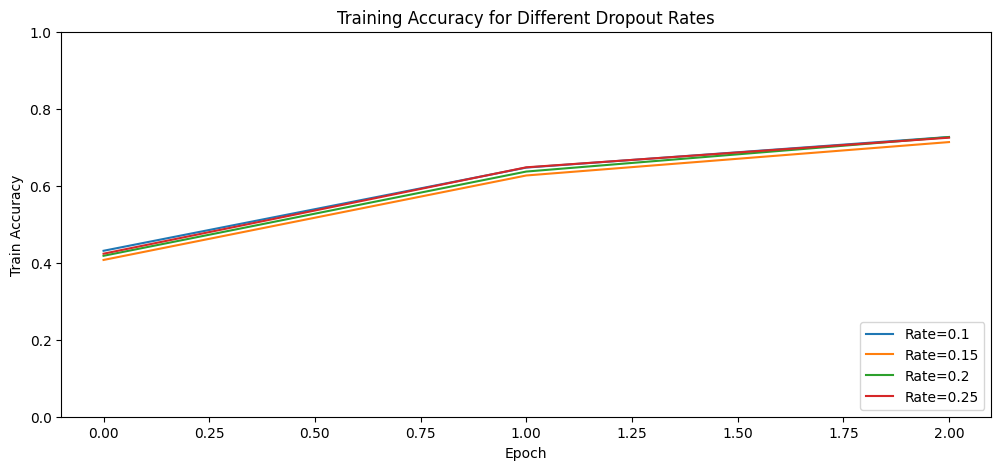

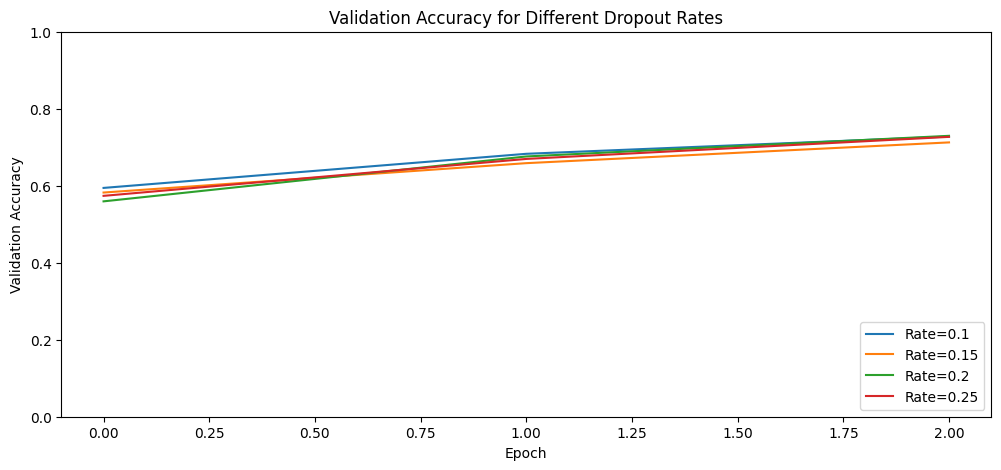

In [ ]:
#Plot the accuracies
plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['accuracy'], label=f'Rate={dropout_rates[i]}')

plt.title('Training Accuracy for Different Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['val_accuracy'], label=f'Rate={dropout_rates[i]}')

plt.title('Validation Accuracy for Different Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


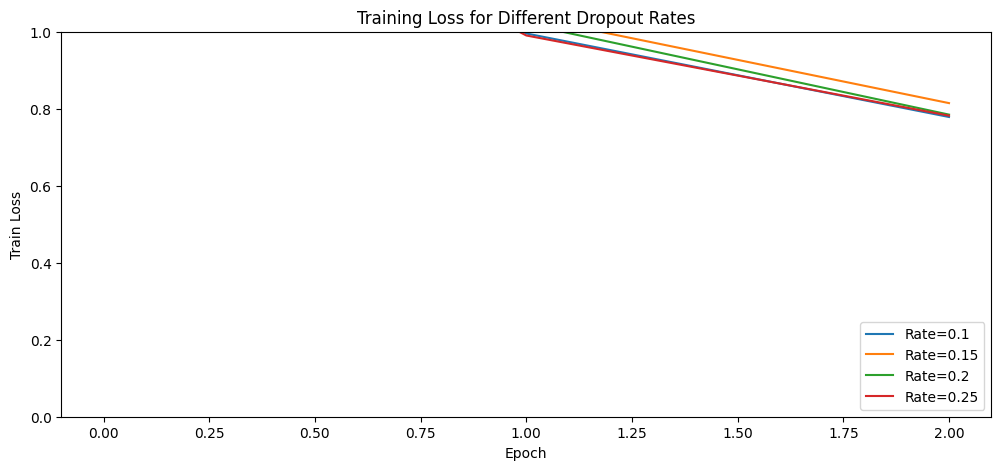

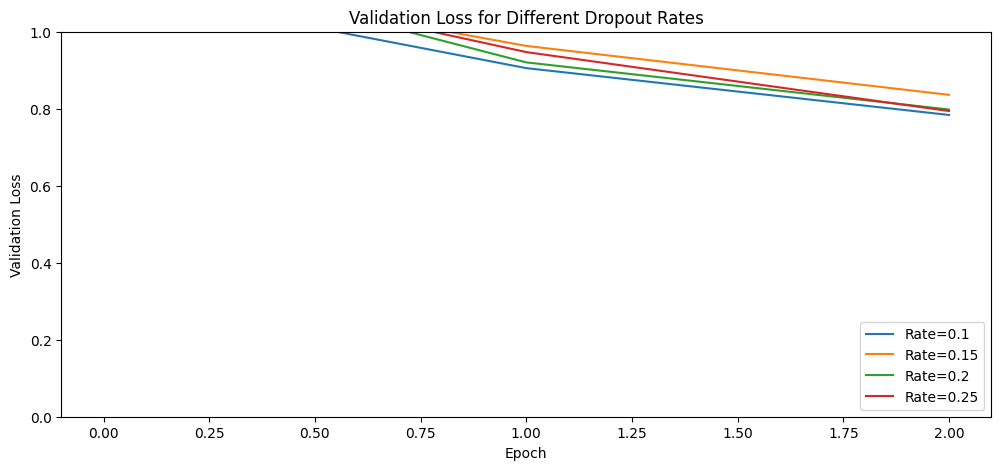

In [ ]:
#plot loss
plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['loss'], label=f'Rate={dropout_rates[i]}')

plt.title('Training Loss for Different Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['val_loss'], label=f'Rate={dropout_rates[i]}')

plt.title('Validation Loss for Different Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



## Save the trained Model

In [ ]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save('cifar10_cnn_weights.h5')


## Load the trained Model

In [ ]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar10_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar10_cnn_weights.h5')